# Projet numérique de Science des Données 2025

## Binôme numéro 20 -- GARCIA HARLOUCHET, Ivan et CLIMAUD, Arthur

## Introduction

Dans ce projet, il s'agira d'étudier un jeu de données concernant des femmes diabétiques enceintes. Le diabète constitue un facteur de risque pour le bon déroulé de la grossesse. Pour chacune de ces femmes, nous disposons de 7 variables :
* `Age` : l'âge en années
* `Tension systolique` : la tension systolique en mmHg
* `Tension diastolique` : la tension diastolique en mmHg
* `Glycémie` : glycémie post-prandiale en mmol/L
* `Température` : température en °C
* `FC au repos` : fréquence cardiaque au repos
* `Risque` : degré de risque obstétrique (0 : faible, 1 : moyen, 2 : élevé)


Ce projet comporte trois partie :
1. Une analyse exploratoire des données
2. La construction d'un classifieur binaire permettant de séparer les femmes dont la grossesse est à risque de celles dont elle ne l'est pas
3. La construction d'un classifieur multi-classe permettant de séparer les grossesses en trois classes : hautement à risque, moyennement à risque, faiblement à risque.

## Instructions 
* Former un binôme et l'inscrire dans Moodle.
* Renseigner le numéro de binôme et vos noms tout en haut de ce notebook à l'emplacement indiqué.
* Déposer ce notebook complété **au plus tard le 10 juillet 2025, 23h59** sur Moodle.

La présence aux séances dédiés au mini-projet (20/06 et 7/07) est **notée**. 

Les questions **1 à 14** peuvent être traitées dès la première séance. 
La question **15** peut être traitée après la PC4.
Les questions **16 à 30** peuvent être traitées à partir de la PC5.

Pour des raisons pédagogiques (voir la note à ce sujet), **l'usage d'assistants de code ou d'agents conversationnels tels que ChatGPT, Copilot, Claude, LeChat est prohibé. Leur utilisation sera sanctionnée.**

### Question 1 (1pt)

Les données ont été récoltées dans une région défavorisée du monde, où les populations sont très pauvres et peuvent difficilement consulter. Quel peut être l'intérêt de déléguer à un algorithme la prédiction du risque obstétrique ? Quelles peuvent être les dérives (sociales, éthiques, économiques, psychologiques) d'une telle pratique ?

Il peut être difficile d'aller sur place, et les coûts sont ainsi énormément diminués, favorisant l'étude.

Les risques sont que l'on néglige totalement la diversité des esprits et des corps humains. Chaque personne est différente, et l'on ne prend pas en compte les spécificités de chacun. Mais il y a un risque pour que l'on en abuse et que les résultats ne correspondent pas et que l'on se trompe totalement. 

## Librairies usuelles

In [36]:
import pandas as pd

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

plt.rc('font', **{'size': 12}) # règle la taille de police globalement pour les plots (en pt)

np.random.seed(19) 

## Chargement des données

Nous allons pour l'instant travailler avec le jeu de données d'entraînement `data/donnees_entrainement.csv` :

In [37]:
df_train = pd.read_csv('donnees_entrainement.csv')

Commençons par en extraire deux arrays, `X_train` et `y_train`, contenant d'une part les variables décrivant les observations et d'autre part leurs étiquettes :

In [38]:
X_train = np.array(df_train.drop('Risque', axis=1))
y_train = np.array(df_train['Risque'], dtype='int')

# 1. Exploration de données

## Distributions des variables

### Question 2 (1 pt)
Pour chaque variable, affichez un histogramme de sa distribution dans chacune des trois classes.

In [39]:
df_train[df_train['Risque'] == 0]

,Age,Tension systolique,Tension diastolique,Glycémie,Température,FC au repos,Risque
2,15.5,120.0,75.0,7.4,39.0,74.0,0
6,34.5,90.0,65.0,6.9,36.7,79.0,0
9,18.5,85.0,60.0,7.0,36.6,65.0,0
17,20.5,120.0,80.0,6.7,36.8,90.0,0
18,41.0,120.0,75.0,7.5,36.2,68.0,0
...,...,...,...,...,...,...,...
785,43.0,125.0,75.0,7.6,36.7,67.0,0
795,27.5,90.0,55.0,7.5,37.1,89.0,0
796,32.0,115.0,90.0,7.6,36.2,71.0,0
797,53.5,100.0,70.0,7.7,36.2,68.0,0


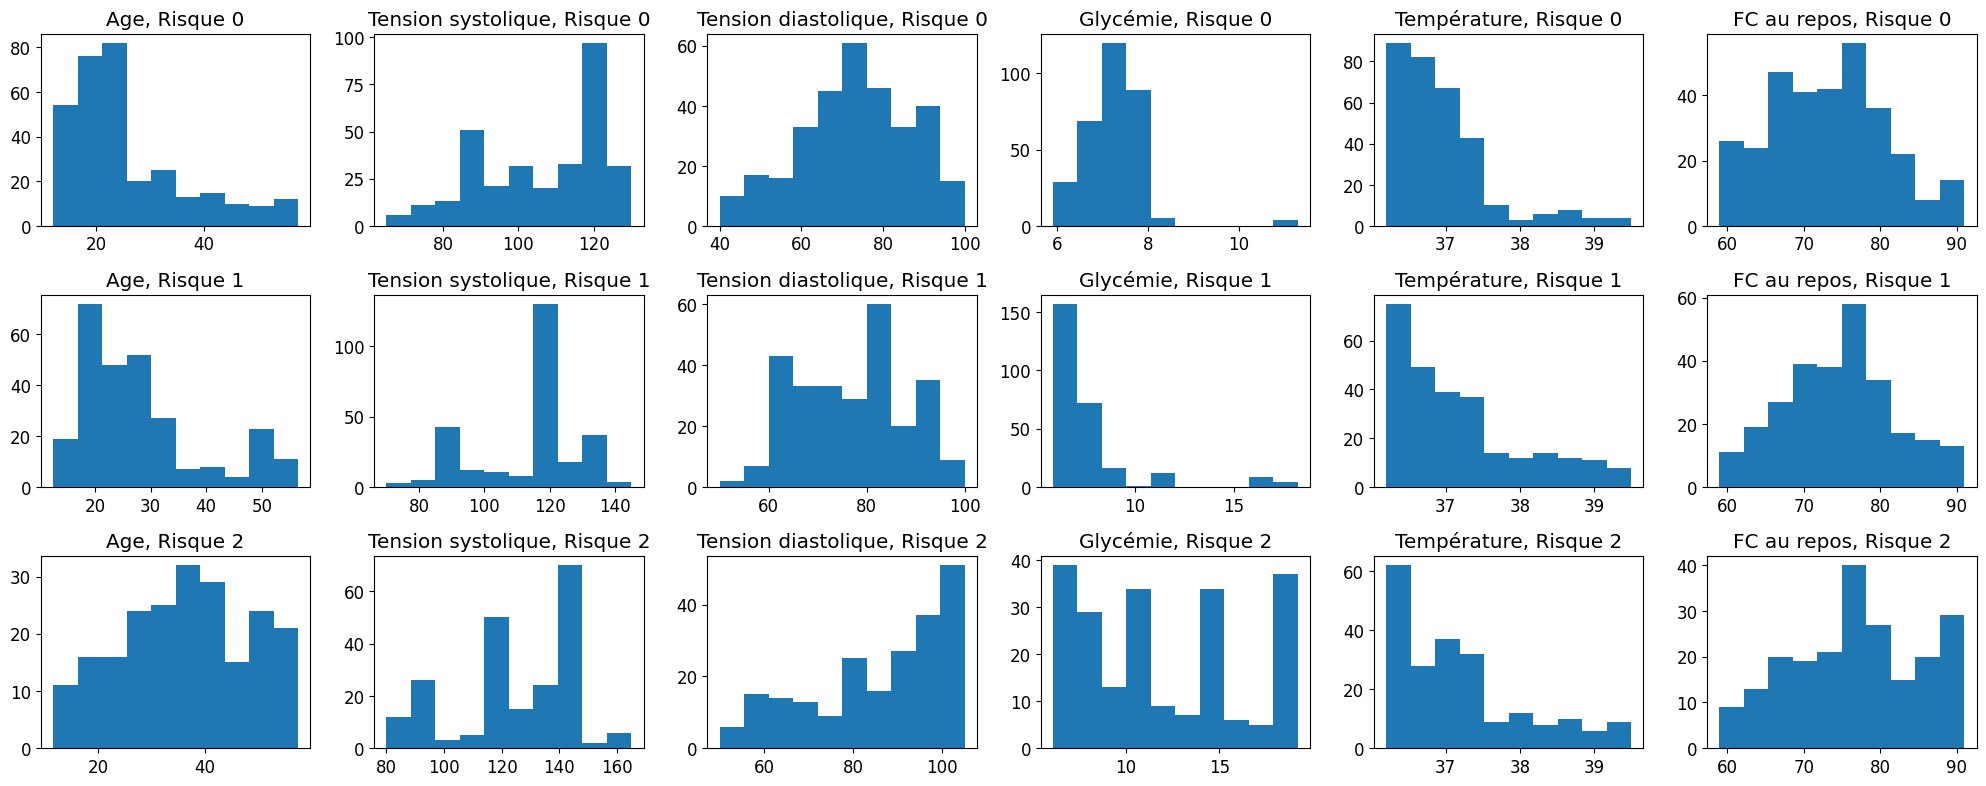

In [40]:
fig = plt.figure(figsize=(20, 8))

# Histogrammes pour les variables continues
for i in range(3):
    for (feat_idx, feat_name) in enumerate(df_train.columns[:6]):
        # créer une sous-figure (subplot) à la position (feat_idx+1) d'une grille 2x5
        ax = fig.add_subplot(3, 6, (6*i + feat_idx+1))

        # afficher l'histogramme de la variable feat_name
        h = ax.hist(df_train[df_train['Risque'] == i][feat_name], bins=10, edgecolor='none')

        # utiliser le nom de la variable comme titre pour chaque histogramme
        ax.set_title(feat_name + ', Risque ' + str(i))

# espacement entre les subplots
fig.tight_layout(pad=1.0)
    

### Question 3 (1 pt)
Les valeurs prises par ces variables sont-elles surprenantes ? Cohérentes avec le degré de risque ?

Plus les personnes sont agées, plus le risque est élevé ce qui est cohérent.

### Question 4 (1 pt)
Pensez-vous qu'il va être facile/difficile de prédire le risque de grossesse à risque en utilisant ces 6 variables ?

Non, il nous manque des données, un jeu de test montrant si avec certains paramètres on peut tomber enceinte ou non

## Réduction de dimension

Indépendamment de votre réponse à la question précédente, nous allons procéder à deux tentatives de réduction de dimension.

### Question 5 (1 pt)
Utilisez la décomposition en composantes principales de `X_train` pour visualiser les données en deux dimensions.

In [41]:
from sklearn import preprocessing, decomposition

In [42]:
std_scale = preprocessing.StandardScaler().fit(X_train)
X_scaled = std_scale.transform(X_train)
pca = decomposition.PCA(n_components=2)
pca.fit(X_scaled)
X_projected = pca.transform(X_scaled)

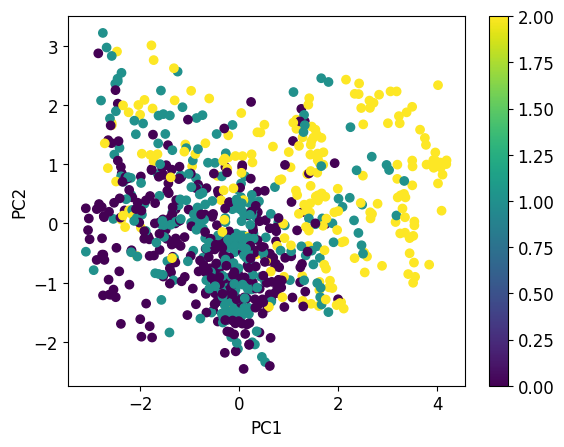

In [43]:
plt.scatter(X_projected[:,0], X_projected[:,1], c=df_train['Risque'])

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar()
plt.show()

### Question 6 (1 pt) 
Pensez-vous utile d'utiliser cette ACP pour réduire la dimension des données pour construire un prédicteur de risque de grossesse difficile ?

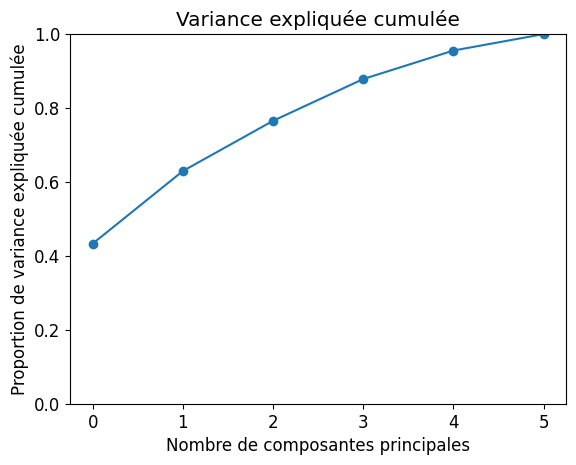

In [44]:
variance_expliquee = decomposition.PCA().fit(X_scaled).explained_variance_ratio_
plt.plot(range(6), np.cumsum(variance_expliquee), marker='o')
plt.title("Variance expliquée cumulée")
plt.xlabel("Nombre de composantes principales")
plt.ylabel("Proportion de variance expliquée cumulée")
plt.ylim(0, 1)
plt.show()

### Question 7 (0,5 pt)
Affichez la matrice de corrélation entre les variables (étiquette exclue)

<Axes: >

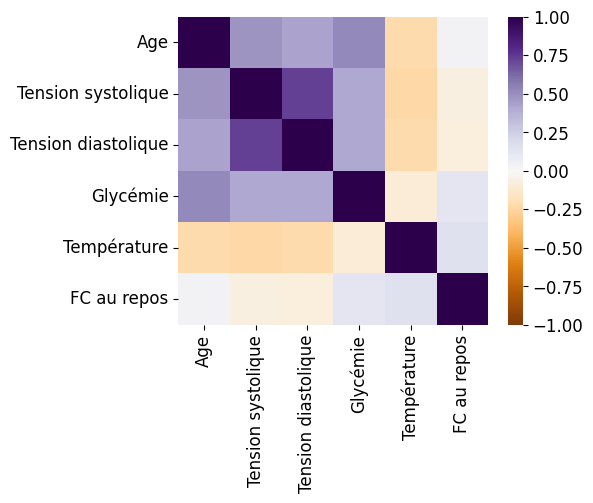

In [64]:
import seaborn as sns

corr_mat = df_train.drop('Risque', axis=1).corr() # enlever origin dont les valeurs numériques ne sont qu'un encodage de régions du monde.
plt.figure(figsize=(5, 4))
# Affichage heatmap
sns.heatmap(corr_mat, 
            vmin=-1, # borne inf des valeurs à afficher
            vmax=1, # borne sup des valeurs à afficher
            center= 0, # valeur médiane des valeurs à afficher,
            cmap='PuOr', # colormap divergente de violet (PUrple) vers orange (ORange)
           )

### Question 8 (0,5 pt)

Comment utiliser cette matrice de corrélation pour réduire la dimension des données ?

Si deux variables sont tres correlées, on pourrait se limiter à n'en garder qu'une d'entre elles.

# 2. Classification «à risque» vs «sans risque»

Nous allons maintenant transformer les étiquettes en étiquettes binaire, en regroupant les risques obstétriques moyens et élevés. Les étiquettes `1` et `2` seront regroupées en une seule étiquette `1`.

In [53]:
# Copier le dataframe initial dans un nouveau dataframe 
df_train_risk_vs_norisk = df_train.copy()

# Regrouper les étiquettes 1 et 2
df_train_risk_vs_norisk['Risque'] = np.where(df_train['Risque']==2, 1, df_train['Risque'])

# Extraction de l'array d'étiquettes
y_train_risk_vs_norisk = np.array(df_train_risk_vs_norisk['Risque'], dtype='int')

## Choix du critère d'évaluation
Pour cette section, on pourra se référer à la section 8.7.1 du poly.

### Question 9 (0,25 pt)
Quelle serait l'_accuracy_ (proportion d'observations correctement étiquetées) d'un modèle qui prédit que toutes les observations appartiennent à la classe majoritaire (c'est-à-dire la classe ayant le plus grand nombre d'observations dans les données) ? 

In [62]:
classe_0 = df_train_risk_vs_norisk[df_train_risk_vs_norisk['Risque'] == 0].shape[0] 
total = df_train_risk_vs_norisk.shape[0]
print("La proba pour un modèle qui prédit que les observations appatiennent à la classe 0 est: ",classe_0/total)
print("La proba pour un modèle qui prédit que les observations appatiennent à la classe 1 est: ", 1- classe_0/total)

La proba pour un modèle qui prédit que les observations appatiennent à la classe 0 est:  0.395
La proba pour un modèle qui prédit que les observations appatiennent à la classe 1 est:  0.605


### Question 10 (0,25 pt) 
La __précision équilibrée__ (_balanced accuracy_) d'un classifieur binaire est donnée par :

$$BA = \frac12 \left( \frac{\text{TP}}{\text{TP}+\text{FN}} +  \frac{\text{TN}}{\text{TN}+\text{FP}} \right)$$

Expliquez pourquoi ce critère d'évaluation est plus pertinent que l'accuracy pour sélectionner un classifieur optimal.

La balanced accuracy est plus pertinente que l’accuracy puisqu'elle accorde la même importance aux bons guess en positif comme en négatif.
Ceci est particulièrement visible dans des cas comme le précedent, où y a un déséquilibre entre les classes, car elle évite qu’un modèle soit évalué favorablement simplement en prédisant la classe majoritaire. Elle permet donc une évaluation plus juste et plus robuste, en particulier dans des contextes médicaux ou critiques où détecter les cas rares est essentiel.

Dans la suite du projet, nous utiliserons ce critère, implémenté dans la méthode [metrics.balanced_accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html) de scikit-learn.

## Plus proche voisin
L'algorithme du plus proche voisin associe à une observation $\vec{x}$ l’étiquette du point du jeu d’entraînement dont elle est la plus proche (par défaut, en distance euclidienne).

### Question 11 (0,5 pt)
En quoi consiste la phase d'entraînement d'un tel classifieur ?

Cette phase consiste à enregistrer les positions de chaque point du jeu d'entrainement.

### Question 12 (0,5 pt)
Quelle précision équilibrée attendez-vous _sur le jeu d'entraînement_ d'un algorithme du plus proche voisin ? Pourquoi ?

Etant donnée que la precision ne prend en compte que les données d'entrainement, et que pour une valeur donnée, celle ci est à une distance de 0 d'elle même, elle seront toutes bonnes, c'est à dire une précision de 1.

### Question 13 (0,5 pt)
Vérifiez votre réponse sur les données, en utilisant la classe [neighbors.KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html).

In [71]:
from sklearn.neighbors import KNeighborsClassifier

modele = KNeighborsClassifier(1).fit(X_train, y_train_risk_vs_norisk)
prediction = modele.predict(X_train)

In [75]:
TP = np.sum((prediction == 1) & (y_train_risk_vs_norisk == 1))
TN = np.sum((prediction == 0) & (y_train_risk_vs_norisk == 0))
FP = np.sum((prediction == 1) & (y_train_risk_vs_norisk == 0))
FN = np.sum((prediction == 0) & (y_train_risk_vs_norisk == 1))

BA = 0.5 * (TP / (TP + FN) + TN / (TN + FP))
print(BA)

1.0


### Quesion 14 (0,5 pt)
Pour cet algorithme, vaut-il mieux utiliser les données d'origine ou les données centrées-réduites ? Justifiez votre réponse.

Il vaut mieux utiliser les données centrées réduites, car si les variables d'origine ont des échelles très différentes, celles avec une plus grande plage de valeurs domineront le calcul de la distance. 
Par exemple, en utilisant les données d'origine, si une des variables varie entre 0 et 10, et qu'une autre le fait entre 0 et 1000, la deuxième variable aura un impact disproportionné sur la distance calculée simplement en raison de son échelle plus grande.

## K plus proches voisins
L'algorithme des $K$ plus proche voisins associe à une observation $\vec{x}$ l’étiquette qui est majoritaires parmi celle des $K$ points du jeu d’entraînement dont elle est la plus proche (par défaut, en distance euclidienne).

### Question 15 (1,5 pt)
Utilisez une recherche sur grille avec une validation croisée en 10 _folds_ (voir amphi 7 et PC5) pour déterminer une valeur optimale de $K$. 

* Justifiez votre choix de grille de valeurs.
* Illustrez par un graphique approprié votre exploration de cette grille.
* Commentez ce graphique.
* Reportez la valeur optimale de l'hyperparamètre et la précision équilibrée correspondante.

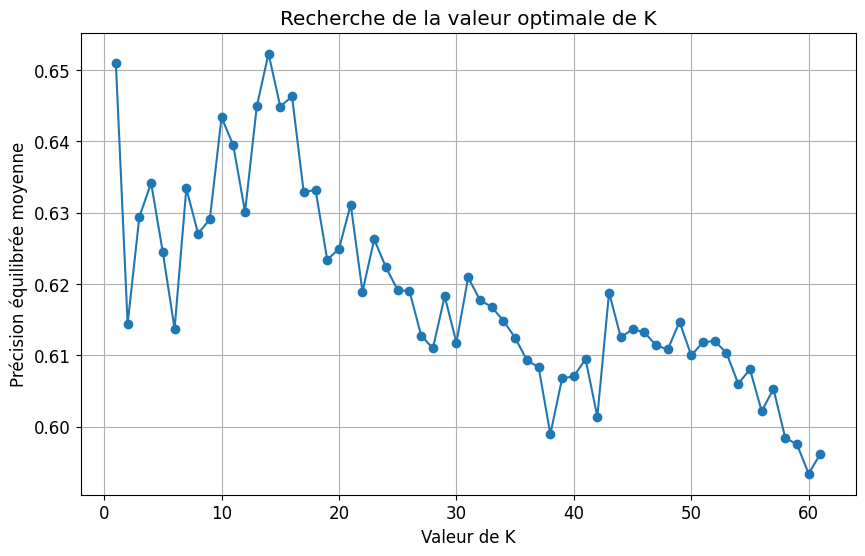

(np.int64(14), np.float64(0.6522687027727349))

In [90]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_neighbors': np.arange(1, 62)}

knn = KNeighborsClassifier()


grid_search = GridSearchCV(knn, param_grid, cv=10, scoring='balanced_accuracy')
grid_search.fit(X_train, y_train)

results = grid_search.cv_results_

plt.figure(figsize=(10, 6))
plt.plot(param_grid['n_neighbors'], results['mean_test_score'], marker='o')
plt.xlabel('Valeur de K')
plt.ylabel('Précision équilibrée moyenne')
plt.title('Recherche de la valeur optimale de K')
plt.xticks(range(0,70,10))
plt.grid(True)
plt.show()

best_k = grid_search.best_params_['n_neighbors']
best_score = grid_search.best_score_

best_k, best_score

## Régression logistique
Le pendant pour la classification binaire de la régression linéaire (amphi 7 et PC 5) est la __régression logistique__ (PC 6). Dans scikit-learn, elle est implémentée par la classe [linear_model.LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

### Question 16 (1 pt) 
Utilisez une recherche sur grille avec une validation croisée en 10 _folds_ pour déterminer une valeur optimale du coefficient de régularisation d'une régression logistique. 

* Justifiez votre choix de type de régularisation et de grille de valeurs. 
* Illustrez par un graphique approprié votre exploration de cette grille. 
* Commentez ce graphique.
* Reportez la valeur optimale de l'hyperparamètre et la précision équilibrée correspondante.

## Algorithme non-linéaire

### Question 17 (2pt)
Choisissez maintenant un algorithme permettant d'apprendre un modèle non-linéaire parmi ceux du chapitre 9 :
* arbre de décision : [tree.DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)
* forêt aléatoire : [ensemble.RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
* machine à vecteur de support à noyau : [svm.SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)
* perceptron multi-couche : [neural_network.MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)

Utilisez encore une fois une recherche sur grille avec une validation croisée en 10 _folds_ pour sélectionner le(s) hyperparamètre(s) le(s) plus pertinent(s).

* Justifiez votre choix d'hyperparamètre(s) à optimiser.
* Justifiez votre choix de grille de valeurs pour ces ou cet hyperparèmtre(s).
* Illustrez par un graphique approprié votre exploration de cette grille.
* Commentez ce graphique.
* Reportez la ou les valeur(s) optimale(s) d'hyperparamètre(s) et la précision équilibrée correspondante.

## Classification après réduction de dimension

Nous allons maintenant évaluer l'impact d'une réduction de dimension sur la qualité de l'apprentissage.

### Question 18 (0,25 pt)
Quel algorithme (k plus proches voisins ; régression logistique ; algorithme non-linéaire de la question 16) vous a permis d'obtenir la meilleure performance ? 

### Quesion 19 (0,25 pt)
Utilisez le travail des questions 4 à 7 pour créer une nouvelle matrice représentant les données dans moins de dimensions qu'originellement. 

### Question 20 (0,25 pt)
Utilisez encore une fois une recherche sur grille pour optimiser les performances de cet algorithme, mais entrainé sur cette nouvelle matrice. 

### Question 21 (0,25 pt)
La réduction de dimension a-t-elle été utile ? Commentez.

## Classifieur final

### Question 22 (0,25 pt)
Au vu des performances observées jusqu'à présent, quel est l'algorithme d'apprentissage, son ou ses valeurs d'hyperparamètres, la transformation des données qui permettent d'obtenir la meilleure performance ? 

Utilisez cet algorithme pour entraîner un modèle de classification final `final_binary_classifier` sur l'ensemble du jeu d'entraînement.

### Question 23 (0,25 pt)

Chargez les données du jeu de test `data/donnees_reservees.csv`. Combinez les étiquettes 1 et 2 en une seule classe. 

### Question 24 (0,25 pt)

Utilisez `final_binary_classifier` pour prédire les étiquettes des observations de ce jeu de données. (N'oubliez pas d'appliquer d'éventuelles transformation des données.) 

### Question 25 (0,5 pt)
Comparez la précision équilibrée sur le jeu de test à celle obtenue en validation croisée lors de la sélection de modèle. Commentez.

### Question 26 (0,25 pt)
Utilisez [metrics.ConfusionMatrixDisplay](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html) pour afficher la matrice de confusion de ces prédictions.

### Question 27 (0,5 pt)
Commentez cette matrice de précision.

Considéreriez vous possible d'utilise ce classifieur pour décider, sur la base de ces quelques mesures faciles à obtenir en autonomie, quelles femmes référer pour un suivi médical attentif de leur grossesse ?

# 3. Classification multi-classe

### Question 28 (0,5 pt)
Parmi les algorithmes d'apprentissage supervisé que vous avez utilisé dans la section 2, le(s)quel(s) se prête(nt) directement à entraîner un classifieur multiclasse ?

### Question 29 (1,5 pt)
Choisissez un des algorithmes mentionnés à la question précédente et entraînez-le sur le problème de classification multi-classe consistant à prédire le niveau (0, 1 ou 2) de risque obstétrique. Optimisez le ou les hyperparamètre(s) le(s) plus pertinent(s).

### Question 30 (1pt)
Utilisez cet algorithme pour entraîner un modèle multi-classe final sur l'ensemble des données d'entraînement. Évaluez ce modèle sur les données de test. Commentez.